# Simple ODE solvers
This notebook explores the Euler and predictor-corrector methods for solving ODEs

## Euler's method for solving ODEs
In this section we look at the Euler method for solving ODEs. For reasons discussed below this method is rarely used but it is simple to understand.

In [64]:
import numpy as np
import matplotlib.pyplot as plt

# The below commands make the font and image size bigger
plt.rcParams.update({'font.size': 22})
plt.rcParams["figure.figsize"] = (15,10)

The ODE we want to solve is $$\frac{dy}{dx} = -2x - y$$ with initial conditions $x_0 = 0, y_0 = -1$. We have chosen this test case as it has a simlpe analytic solution we can compare against $y(x) = -3e^{-x} -2x +2$

In [3]:
def dydx(x,y):
    return -2*x - y

In [22]:
def yExact(x):
    return - 3*np.exp(-x) - 2*x + 2

In [182]:
def EulerMethod(dydx, yExact, dx, x0, y0, imax, printSteps=False, plotSteps=False):
    i = 0
    xi = x0
    yi = y0
    
    steps = np.zeros((imax+1,2))
    steps[0,0] = x0
    steps[0,1] = y0
    
    # Create a loop to iteratively solve the ODE step-by-step
    while i < imax:
        # The next three lines implement the Euler method
        fi = dydx(xi, yi)
        xi += dx
        yi = yi + dx*fi
        i += 1
        
        if(printSteps):
            diffi = yi - yExact(xi)
            Ei    = np.abs(100*diffi/yExact(xi))
            print("%d %.2f %.5f %.4f %.2f" % (i, xi, yi, diffi, Ei))
            
        # Store the steps for plotting
        steps[i, 0] = xi
        steps[i, 1] = yi    
            
    if(plotSteps):
        plt.scatter(steps[:,0], steps[:,1], color='red', linewidth='10')
        
    return [xi, yi]

1 0.10 -0.90000 0.0145 1.59
2 0.20 -0.83000 0.0262 3.06
3 0.30 -0.78700 0.0355 4.31
4 0.40 -0.76830 0.0427 5.26
5 0.50 -0.77147 0.0481 5.87


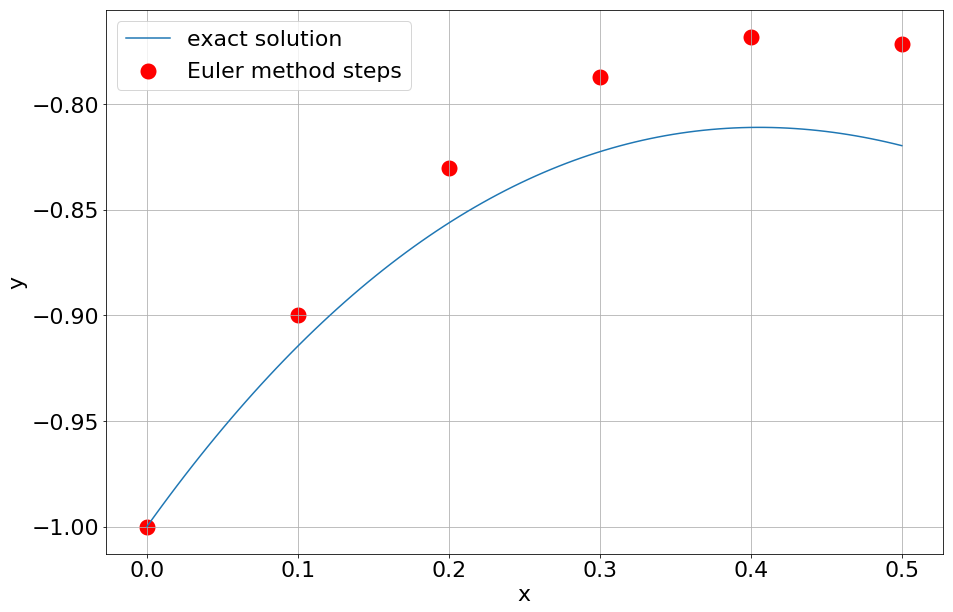

In [202]:
x = np.linspace(0, 0.5, 100)
y = yExact(x)
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.plot(x,y)

EulerMethod(dydx, yExact, 0.1, 0, -1, 5, True, True)
plt.legend(['exact solution', 'Euler method steps']);

### Convergence of the Euler method

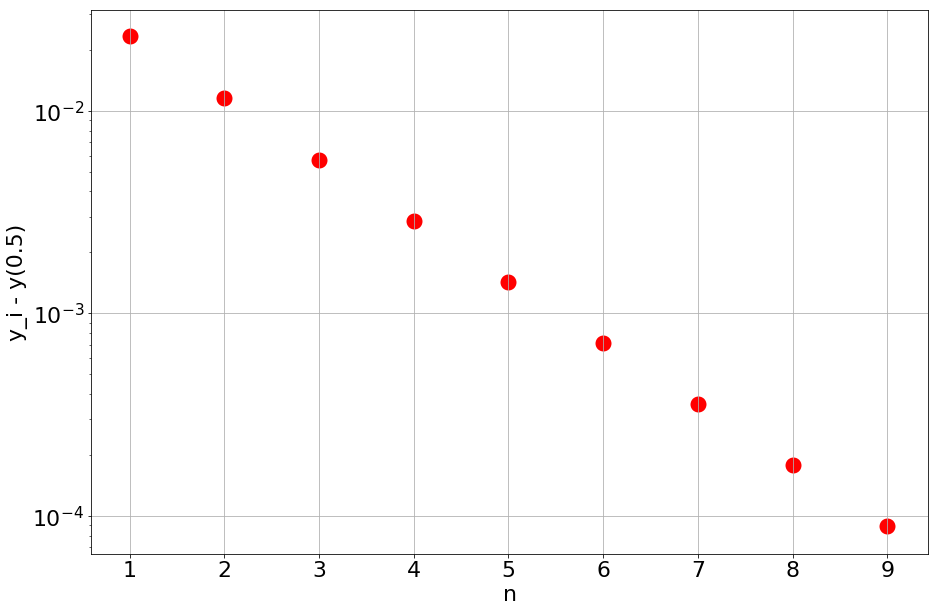

In [203]:
nmax = 10
n = 1

plt.grid(True)
plt.yscale('log')
plt.xlabel('n')
plt.ylabel('y_i - y(0.5)')

while n < nmax:
    res  = EulerMethod(dydx, yExact, 0.1/2**n, 0, -1, 5*2**n)
    diff = res[1] - yExact(0.5)
    plt.scatter(n, diff, color='red', linewidth='10')
    n += 1

### Stability of the Euler method
The Euler method can be unstable, i.e., for some functions will not converge on the correct answer. One example is shown below.

In [187]:
def dxdt(t, x):
    a = 1
    return a*x

In [188]:
def xExact(t):
    a = 1
    return np.exp(a*t)

[0.5, 1.61051]

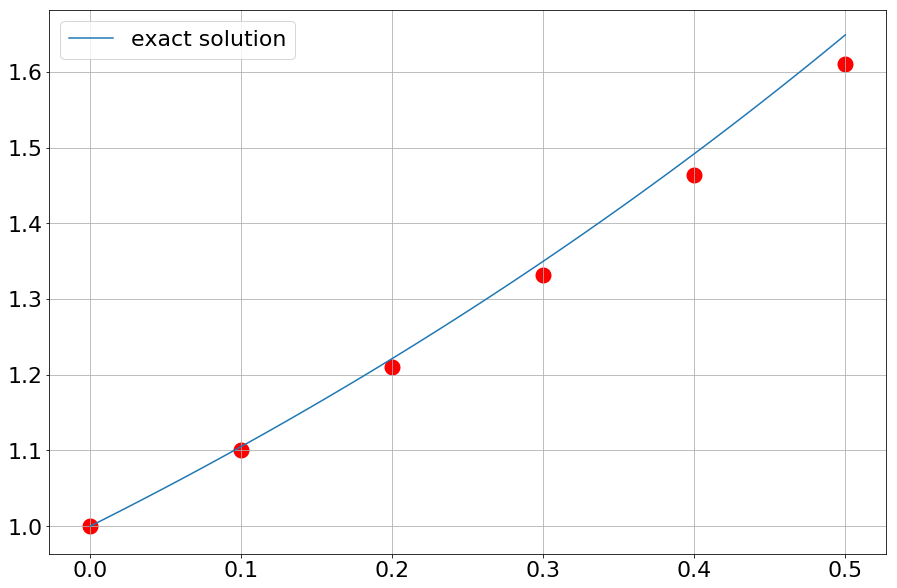

In [193]:
t = np.linspace(0,0.5,100)
x = xExact(t)

plt.grid(True)
plt.plot(t,x)
plt.legend(['exact solution', 'Euler method steps'])

EulerMethod(dxdt, xExact, 0.1, 0, 1, 5, False, True)

If we now perform the error analysis similar to how we did above, we see that the in this case the Euler method does not converge (i.e., the error does not decrease as we decrease the step size)

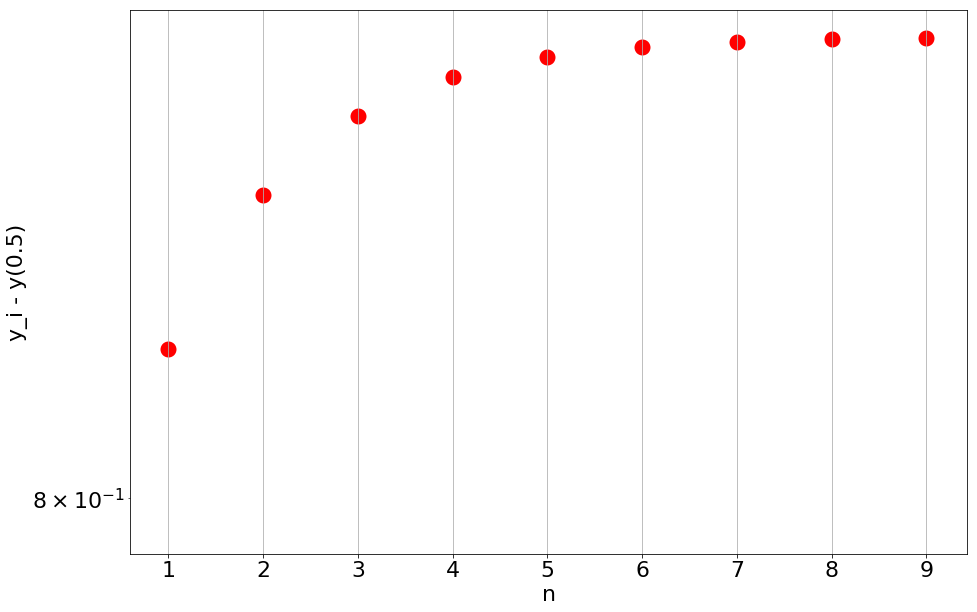

In [194]:
nmax = 10
n = 1

plt.grid(True)
plt.yscale('log')
plt.xlabel('n')
plt.ylabel('y_i - y(0.5)')

while n < nmax:
    res  = EulerMethod(dxdt, xExact, 0.1/2**n, 0, -1, 5*2**n)
    diff = np.abs(res[1] - yExact(0.5))
    plt.scatter(n, diff, color='red', linewidth='10')
    n += 1

The poor convergence properties of the Euler method mean that is never used to solve ODEs in practice. It is mostly a pedagogical tool.

## Predictor-corrector method for solving ODEs

In [180]:
def PredictorCorrector(dydx, dx, x0, y0, imax, printSteps=False, plotSteps=False):
    i = 0
    xi = x0
    yi = y0
    
    steps = np.zeros((imax+1,2))
    steps[0,0] = x0
    steps[0,1] = y0
    
    while i < imax:
        # The next three lines implement the Euler method 
        # as the predictor step
        fi      = dydx(xi, yi)
        xi1     = xi + dx
        ytildei = yi + dx*fi
        
        # We then apply the corrector step which
        # use the average of the slode at x_i and x_{i+1}
        # to compute y_i
        fi1     = dydx(xi1, ytildei)
        xi      = xi1
        yi = yi + dx/2 * (fi + fi1)
        
        i += 1
        
        # Store the steps for plotting
        steps[i, 0] = xi
        steps[i, 1] = yi
        
    if(plotSteps):
        plt.scatter(steps[:,0], steps[:,1], color='orange', linewidth=10)
    
    return [xi, yi]

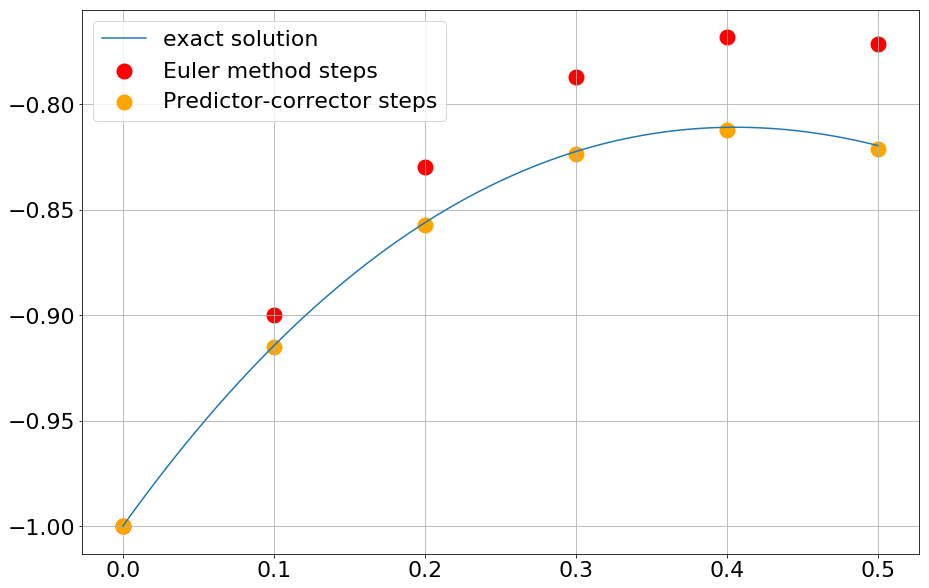

In [270]:
x = np.linspace(0,0.5,100)
y = yExact(x)

plt.grid(True)
plt.plot(x,y)

EulerMethod(dydx, yExact, 0.1, 0, -1, 5, False, True)
PredictorCorrector(dydx, 0.1, 0, -1, 5, False, True)
plt.legend(['exact solution', 'Euler method steps', 'Predictor-corrector steps']);

With the same number of steps it certainly looks like the Predictor-Corrector method is more accurate than the Euler method. Notice that this increase in accuracy comes at a cost, which is the RHS needs to be evaluated twice

### Convergence of the methods
Let's now look at the convergence of the Predictor-corrector method vs the Euler method

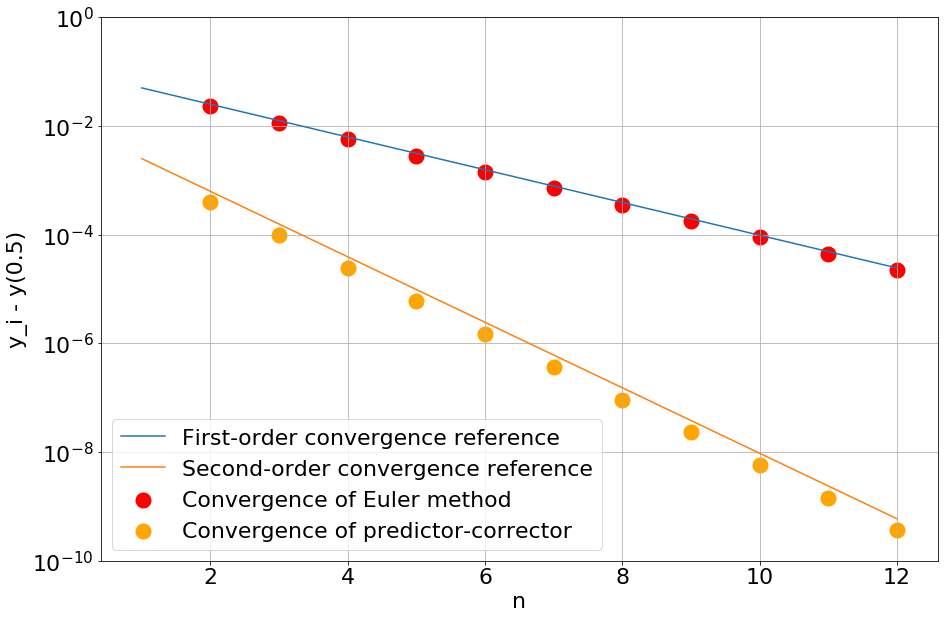

In [266]:
nmax = 12

diffEuler = np.zeros(nmax)
diffPC = np.zeros(nmax)

n = 1
while n < nmax:
    deltax       = 0.1/2**n
    nsteps        = 5*2**n
    resEuler     = EulerMethod(dydx, yExact, deltax, 0, -1, nsteps)
    resPC        = PredictorCorrector(dydx, deltax, 0, -1, nsteps)
    
    diffEuler[n] = np.abs(resEuler[1] - yExact(0.5))
    diffPC[n]    = np.abs(resPC[1] - yExact(0.5))
    n += 1
    
plt.grid(True)
plt.yscale('log')
plt.xlabel('n')
plt.ylabel('y_i - y(0.5)')
plt.ylim([1e-10, 1])

# Compute and plot reference curves for the convergence rate
x           = np.linspace(1, nmax, 12)
deltax      = (0.1/2**x)
firstOrder  = deltax**1
secondOrder = deltax**2

plt.plot(x, firstOrder)
plt.plot(x, secondOrder)

plt.scatter(np.arange(1,nmax+1), diffEuler, color='red', linewidth='10')
plt.scatter(np.arange(1,nmax+1), diffPC, color='orange', linewidth='10')

plt.legend(['First-order convergence reference', 'Second-order convergence reference', 'Convergence of Euler method', 'Convergence of predictor-corrector']);

We thus see that, as expected, the predictor-corrector method is **second-order** convergent, whereas the Euler method is **first-order** convergent